In [1]:
import sys
sys.path.append("../data/neural_data/")
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import analysis_neuro as spk
import plots

In [2]:
%load_ext autoreload
%autoreload analysis_neuro
%autoreload plots

In [3]:
# file paths
data_folder = f"../data/neural_data/"
save_folder = f"../figures/fig1_plots/"

In [4]:
''' load the data '''
m = 'Toronto'
s = '1112_1'
d = {}

# FR by 5cm position bins by trial for each cell
d['Y'] = np.load(f'{data_folder}{m}_{s}_MEC_FRtensor.npy')

# spike count by observation for each cell
d['B'] = np.load(f'{data_folder}{m}_{s}_MEC_spikes.npy')

# behavioral variables by observation - position, speed, trial, time
d['A'] = np.load(f'{data_folder}{m}_{s}_behavior.npy'.format(data_folder, m, s))

# ID numbers for all good cells
d['cells'] = np.load(f'{data_folder}{m}_{s}_MEC_cellIDs.npy')

# keep only cells in MEC
filt_file = f'{data_folder}{m}_{s}_MEC_idx.npy'
cell_idx = np.load(filt_file)
d['cells'] = d['cells'][cell_idx]
d['Y'] = d['Y'][:, :, cell_idx]
d['B'] = d['B'][:, cell_idx]

n_cells = d['cells'].shape[0]
print(f'loaded data for {m}_{s}')

loaded data for Toronto_1112_1


In [5]:
''' k-means to divide by map '''
n_maps = 2

# get trial idx for 2 most common maps
Y = d['Y'].copy()
W, H = spk.get_maps(Y, N=n_maps, M=2)
d['kmeans'] = {}
d['kmeans']['W'] = W
d['kmeans']['H'] = H

# get observation idx for each map
trials = d['A'][:, 2].copy()
map_idx = spk.get_map_idx(W, trials)
d['idx'] = map_idx

In [6]:
# compute firing rates for each map
A = d['A']
B = d['B']

dt = 0.02 
map0_idx = d['idx'][0, :]
map1_idx = d['idx'][1, :]

FR_0, binned_pos, FR_0_sem = spk.tuning_curve(A[map0_idx, 0],
                                              B[map0_idx, :],
                                              dt, b=2, SEM=True)
FR_1, binned_pos, FR_1_sem = spk.tuning_curve(A[map1_idx, 0],
                                              B[map1_idx, :],
                                              dt, b=2, SEM=True)

In [7]:
# get the trial-trial network similarity
Y = d['Y'].copy()
d['sim'] = spk.spatial_similarity(Y)

# compute the distance to k-means cluster
H = d['kmeans']['H']
d['dist'] = spk.clu_distance_population(Y, H, 0)

In [8]:
''' save remap index for plotting '''
W = d['kmeans']['W']
trials = np.arange(0, W.shape[0]-1)

# define remaps
remap_idx = np.asarray([])
for w in range(W.shape[1]):
    remaps = np.where(np.abs(np.diff(W[:, w])))[0]
    remap_idx = np.append(remap_idx, remaps)
remap_idx = np.unique(remap_idx)
remap_idx = remap_idx.astype(int)
d['remap_idx'] = remap_idx

NameError: name 'axis_label' is not defined

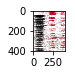

In [9]:
''' fig. 1c: remapping examples for a single cell and the whole network '''
f, gs = plots.plot_fig1c(d=d, cell_ID=433,
                         FR_0=FR_0, FR_1=FR_1,
                         FR_0_sem=FR_0_sem, FR_1_sem=FR_1_sem,
                         binned_pos=binned_pos)

f.savefig(f'{save_folder}{m}_{s}_examples.png',
          dpi=600, bbox_inches='tight')
plt.show()